In [33]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import plotly
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from collections import Counter
plotly.tools.set_credentials_file(username='sathvikn', api_key='ePo8zTuZ5PMFgYjFA9qm')


In [2]:
geo_data = pd.read_json('1940_singh_census_with_geodata.json')
geo_data.columns

Index(['age', 'birthPlace', 'birthPlaceGeocodedData', 'birthPlaceNormalized',
       'birthYearApprox', 'censusLocation', 'censusLocationGeocodedData',
       'censusLocationNormalized', 'children', 'gender', 'identifier',
       'inferredGroups', 'maritalStatus', 'name', 'parents', 'raceRecorded',
       'raceRecordedNormalized', 'relationshipToHead', 'siblings', 'spouse'],
      dtype='object')

In [3]:
len(geo_data.index)

962

In [4]:
geo_data['censusLocationGeocodedData'][0]

{'address': {'country': 'United States of America',
  'country_code': 'us',
  'county': 'Maricopa County',
  'state': 'Arizona'},
 'boundingbox': ['32.5049739', '34.04739', '-113.333755', '-111.0399049'],
 'class': 'boundary',
 'display_name': 'Maricopa County, Arizona, United States of America',
 'icon': 'http://nominatim.openstreetmap.org/images/mapicons/poi_boundary_administrative.p.20.png',
 'importance': '0.94083416919723',
 'lat': '33.34883',
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://www.openstreetmap.org/copyright',
 'lon': '-112.49123',
 'osm_id': '1832201',
 'osm_type': 'relation',
 'type': 'administrative'}

In [5]:
type(geo_data['censusLocationGeocodedData'][0])

dict

In [6]:
coords = [{'lat': data['lat'], 'lon': data['lon'], 'name': data['display_name'], 'county': data['address']['county']} for data in geo_data['censusLocationGeocodedData']]
coords_df = pd.DataFrame(coords)

In [7]:
coords_df.head()

,county,lat,lon,name
0,Maricopa County,33.34883,-112.49123,"Maricopa County, Arizona, United States of Ame..."
1,Maricopa County,33.34883,-112.49123,"Maricopa County, Arizona, United States of Ame..."
2,Maricopa County,33.34883,-112.49123,"Maricopa County, Arizona, United States of Ame..."
3,Maricopa County,33.34883,-112.49123,"Maricopa County, Arizona, United States of Ame..."
4,Maricopa County,33.34883,-112.49123,"Maricopa County, Arizona, United States of Ame..."


In [8]:
fips_mapping = pd.read_csv('fips.csv')
fips_mapping.head()

,state,state_code,county_code,county,fips_class_code
0,AL,1,1,Autauga County,H1
1,AL,1,3,Baldwin County,H1
2,AL,1,5,Barbour County,H1
3,AL,1,7,Bibb County,H1
4,AL,1,9,Blount County,H1


In [9]:
for i in coords_df.county:
    if i not in fips_mapping['county'].values:
        print(i)

Doña Ana County
Doña Ana County
Doña Ana County
Doña Ana County
Doña Ana County
Manhattan
Manhattan
Manhattan
New York


In [10]:
modern_county_mapping = {'New York': 'New York County', 'Manhattan': 
                         'New York County', 'Doña Ana County': 'Dona Ana County'}
replace_county = lambda name: modern_county_mapping[name] if name in modern_county_mapping else name

In [11]:
coords_df['county'] = [replace_county(i) for i in coords_df['county']]

In [12]:
coords_df.merge(fips_mapping, on='county', how='left').shape

(1342, 8)

There were 962 rows in the original dataframe, so we should look at joining by county and state name.

In [13]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}

In [14]:
state_code = [us_state_abbrev[data['address']['state']] for data in geo_data['censusLocationGeocodedData']]
coords_df['state'] = state_code

In [15]:
coords_fips = coords_df.merge(fips_mapping, on=['state', 'county'], how='left')
coords_fips.columns

Index(['county', 'lat', 'lon', 'name', 'state', 'state_code', 'county_code',
       'fips_class_code'],
      dtype='object')

In [16]:
state_codes = coords_fips['state_code'].astype(str)
county_codes = coords_fips['county_code'].astype(str)
def combine_codes(state, county):
    code_lst = []
    for i in np.arange(len(state.index)):
        complete_code = ''
        if len(state[i]) == 1:
            state[i] = '0' + state[i]
        complete_code += state[i]
        if len(county[i]) != 3:
            county[i] = ('0' * (3 - len(county[i]))) + county[i]
        complete_code += county[i]
        code_lst.append(complete_code)
    return code_lst

In [17]:
complete_fips = combine_codes(state_codes, county_codes)
people_per_county = Counter(complete_fips)
fips_codes = list(people_per_county.keys())
counts = list(people_per_county.values())
fig = ff.create_choropleth(fips=fips_codes, values=counts)
py.iplot(fig)

In [18]:
ca_data = coords_fips[coords_fips['state'] == 'CA']
ca_codes = combine_codes(pd.Series(ca_data['state_code'].astype(str).values, index=np.arange(len(ca_data.index))),
              pd.Series(ca_data['county_code'].astype(str).values, index=np.arange(len(ca_data.index))))
ca_per_county = Counter(ca_codes)
fips_ca = list(ca_per_county.keys())
counts_ca = list(ca_per_county.values())
ca_fig = ff.create_choropleth(
    fips=fips_ca, values=counts_ca, scope=['California'],
    round_legend_values=True,
    simplify_county=0, simplify_state=0,
    county_outline={'color': 'rgb(15, 15, 55)', 'width': 0.5},
    state_outline={'width': 1},
    legend_title='pop. per county',
    title='Population of People with Surname "Singh" in California (1940)')
py.iplot(ca_fig)

## Clustering

First, we will look at the data at a glance, to see if we can find patterns by inspection. This will not be on a map, but rather on a coordinate plane.

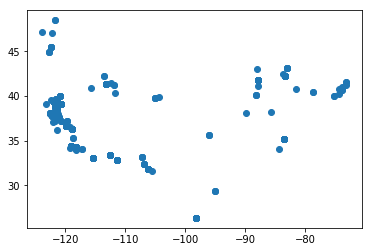

In [159]:
features = ['lat', 'lon']
ll_data = coords_df[features]
ll_data['lat'] = ll_data['lat'].astype('float')
ll_data['lon'] = ll_data['lon'].astype('float')
plt.scatter(ll_data['lon'], ll_data['lat'])

Because the data are already at the scale we want them, and because we want to visualize the clusters on the map, we will run the k-means algorithm for clustering. As $k$ is the number of clusters, we will use the "elbow method" to find the optimal value for $k$, by minimizing the function which relates the sum of the squared errors to the number of clusters. 

If we're going by latitude and longitude alone, it's best to cluster the data as is, mostly the units are already the same. If we standardized it or preprocessed it in any other way, then it would not be interpretable.

In [23]:
from sklearn import preprocessing, cluster

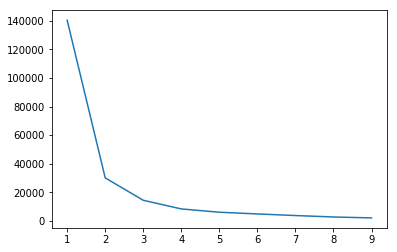

In [22]:
def plot_elbow(data):
    k_counts = np.arange(1, 10)
    sse = []
    for k in k_counts:
        model = cluster.KMeans(n_clusters = k)
        model = model.fit(data)
        sse.append(model.inertia_)
    plt.plot(k_counts, sse)
plot_elbow(ll_data)

The point of inflection in the curve appears to be somewhere between 2, 3, and 4. Let's first visualize the points on a coordinate grid, and then on a map.

In [103]:
def plot_clusters(k, data):
    model = cluster.KMeans(n_clusters = k)
    model = model.fit(data)
    plt.scatter(data['lon'], data['lat'], c=model.labels_.astype(float))
    print(Counter(model.labels_))
    return model

Counter({0: 865, 1: 97})


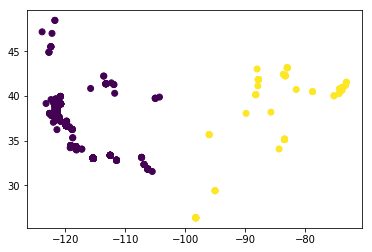

In [104]:
two_clusters = plot_clusters(2, ll_data).labels_

Counter({0: 522, 2: 353, 1: 87})


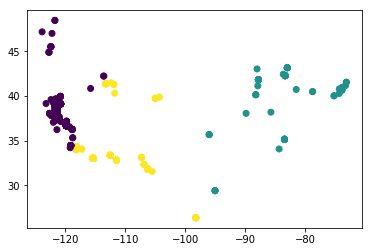

In [105]:
three_clusters = plot_clusters(3, ll_data).labels_

Counter({2: 508, 0: 321, 1: 81, 3: 52})


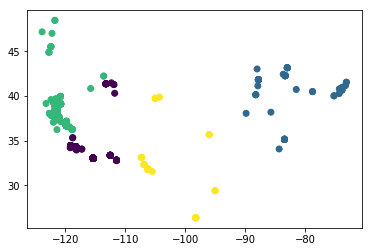

In [37]:
four_clusters = plot_clusters(4, ll_data)

In [38]:
def add_cluster_col(name, labels, data):
    data[name] = labels

In [160]:
args = [('clusters_2', two_clusters), ('clusters_3', three_clusters), ('clusters_4', four_clusters)]
for t in args:
    add_cluster_col(t[0], t[1], ll_data)

In [40]:
ll_data.head()

,lat,lon,clusters_2,clusters_3,clusters_4
0,33.34883,-112.49123,1,0,0
1,33.34883,-112.49123,1,0,0
2,33.34883,-112.49123,1,0,0
3,33.34883,-112.49123,1,0,0
4,33.34883,-112.49123,1,0,0


In [79]:
def counts_per_cluster(data, k):
    return data.groupby(['lat', 'lon', 'clusters_'+ str(k)]).agg('count').reset_index()
grouped = counts_per_cluster(ll_data, 2)
grouped[]

,lat,lon,clusters_2,clusters_3,clusters_4
0,26.353026,-98.216445,0,10,10
1,29.387225,-94.992736,0,3,3
2,31.538863,-105.475295,1,1,1
3,31.806430,-106.222092,1,21,21
4,32.328170,-106.849424,1,5,5
5,32.808585,-111.442621,1,10,10
6,33.030549,-115.359567,1,229,229
7,33.116594,-107.256942,1,4,4
8,33.348830,-112.491230,1,21,21
9,33.940014,-118.132569,1,1,1


In [88]:
def map_clusters(k, data):
    map_data = [dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lat = data['lat'],
        lon = data['lon'],
        mode = 'markers',
        marker = dict(
            size = 5,
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol = 'circle',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            color = data['clusters_' + str(k)],

        ))]

    layout = dict(
            title = 'Assigned Clusters (k = ' + str(k) + ')',
            geo = dict(
                scope='usa',
                projection=dict( type='albers usa' ),
                showland = True,
                landcolor = "rgb(250, 250, 250)",
                subunitcolor = "rgb(217, 217, 217)",
                countrycolor = "rgb(217, 217, 217)",
                countrywidth = 0.5,
                subunitwidth = 0.5
            ),
        )

    fig = dict(data=map_data, layout=layout)
    return fig

If $k=2$, we see a division between the eastern and western US

In [89]:
py.iplot(map_clusters(2, ll_data))

If $k = 3$, we see a distinction between Eastern US, Southwestern US, Western US

In [117]:
py.iplot(map_clusters(3, ll_data))

If $k = 4$, clusters are roughly in Northern CA/Pacific NW, Southern CA, AZ, UT, Midwestern US, Eastern US

In [119]:
py.iplot(map_clusters(4, ll_data))

Let's now try limiting our analysis to the state of California to find clusters within the state.

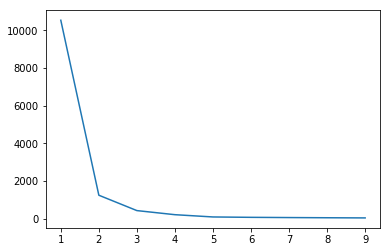

In [111]:
ca_data = coords_fips[coords_fips['state']=='CA'][features]
plot_elbow(ca_data)

Again, the optimal number of clusters appears to be around 3 or 4. 

When trying to visualize data for California itself, we find a high concentration of people in one cluster (Imperial County), so we will only plot the clusters, and scale them with respect to size.

Counter({0: 229, 1: 229, 3: 160, 2: 104, 4: 46})


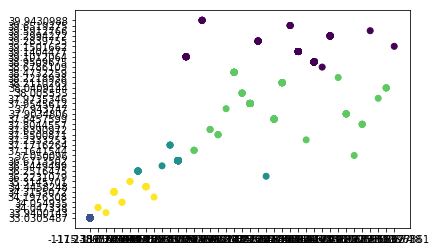

In [127]:
five_ca = plot_clusters(5, ca_data)
cluster_centers = pd.DataFrame(five_ca.cluster_centers_, columns=['lat', 'lon'])
cluster_centers['count'] = Counter(five_ca.labels_).values()
cluster_centers['cluster_id'] = np.arange(5)

In [128]:
cluster_centers

,lat,lon,count,cluster_id
0,39.126342,-121.583193,160,0
1,33.030549,-115.359567,229,1
2,36.635864,-119.722519,104,2
3,37.980862,-121.457478,229,3
4,34.356393,-118.419687,46,4


In [130]:
map_data = [dict(
    type = 'scattergeo',
    locationmode = 'USA-states',
    lat = cluster_centers['lat'],
    lon = cluster_centers['lon'],
    text = cluster_centers['count'],
    mode = 'markers',
    marker = dict(
        size = cluster_centers['count'] / 3,
        opacity = 0.8,
        reversescale = True,
        autocolorscale = False,
        symbol = 'circle',
        line = dict(
            width=1,
            color='rgba(102, 102, 102)'
        ),
        color = cluster_centers['cluster_id']

    ))]

layout = dict(
        title = 'Assigned Clusters (k = 5)',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5
        ),
    )

fig = dict(data=map_data, layout=layout)
py.iplot(fig)

With the k-means algorithm, data points are biased towards being parts of denser clusters. With this distribution of data, we see several "outliers" that are in the same cluster as people who may not necessarily been living in similar conditions. An alternative approach we can turn to is DBSCAN(Density-based spatial clustering of applications with noise). Here, the number of clusters is not predetermined, and points that are outliers are not forced into a cluster. The hyperparameters for DBSCAN are the minimum number of items per cluster, and $\epsilon$, the minimum distance for two points to be clustered together. We choose to use the hierarchical version of DBSCAN (HDBSCAN), because it works on clusters of varying densities, and also because the only hyperparameter is the minimum amount of points in each cluster. Based on domain knowledge, we set this value to be 100, a little over 10% of the number of data points (962).

In [131]:
import hdbscan

In [167]:
algo = hdbscan.HDBSCAN(min_cluster_size=100)
cluster_labels = algo.fit_predict(ll_data)
ll_data['hdbscan_clusters'] = cluster_labels
grouped_us = ll_data.groupby(['lat', 'lon', 'hdbscan_clusters']).agg('count')
grouped_us = grouped_us.drop(grouped_us.columns[1:], axis = 1).rename(index=str, columns={'clusters_2': 'Count'}).reset_index()
grouped_us.head()

,lat,lon,hdbscan_clusters,Count
0,26.3530256,-98.216445,-1,10
1,29.3872254,-94.992736,-1,3
2,31.5388627,-105.4752945,-1,1
3,31.8064303,-106.2220924,-1,21
4,32.32817,-106.8494235,-1,5


In [189]:
size_gen = lambda count : count / 1.5 if count > 0 else count
grouped_us['size'] = grouped_us['Count'].apply(size_gen)
hdbscan_data = [dict(
    type = 'scattergeo',
    locationmode = 'USA-states',
    lat = grouped_us['lat'],
    lon = grouped_us['lon'],
    text = grouped_us['Count'],
    mode = 'markers',
    marker = dict(
        size = grouped_us['Count'],
        opacity = 0.8,
        reversescale = True,
        autocolorscale = False,
        symbol = 'circle',
        line = dict(
            width=1,
            color='rgba(102, 102, 102)'
        ),
        color = ll_data['hdbscan_clusters']

    ))]

layout = dict(
        title = 'Assigned Clusters (HDBSCAN)',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5
        ),
    )

fig = dict(data=hdbscan_data, layout=layout)
py.iplot(fig)